# GAN 모델 만들기

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________
epoch:0  d_loss:0.7127  g_loss:0.5844
epoch:1  d_loss:0.5283  g_loss:0.2971
epoch:2  d_loss:0.5568  g_loss:0.1412
epoch:3  d_loss:0.5645  g_loss:0.1602
epoch:4  d_loss:0.5209  g_loss:0.2703
epoch:5  d_loss:0.4470  g_loss:0.5196
epoch:6  d_loss:0.4152  g_loss:0.7478
epoch:7  d_loss:0.4055  g_loss:0.9825
epoch:8  d_loss:0.4009  g_loss:1.0522
epoch:9  d_loss:0.3923  g_loss:0.

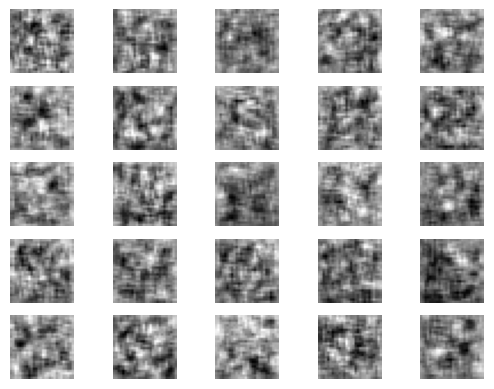

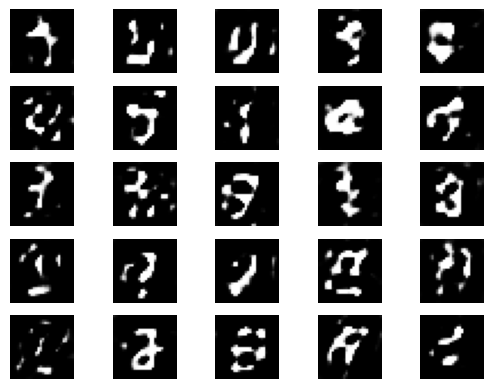

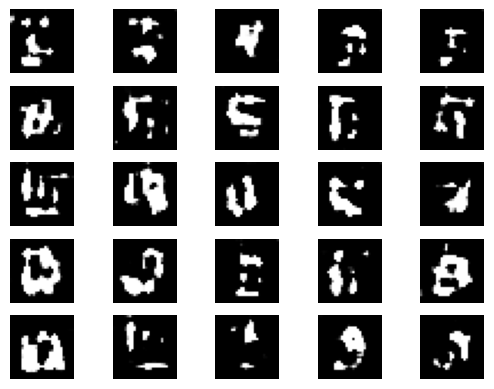

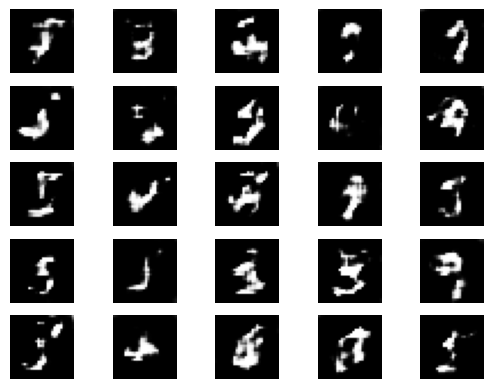

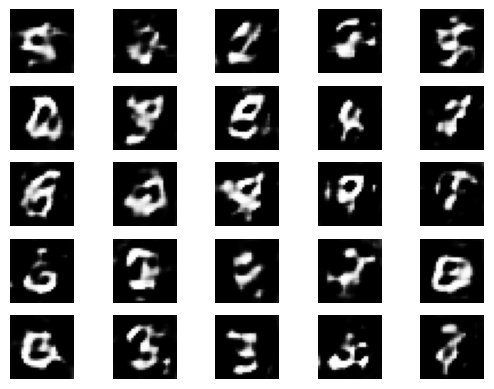

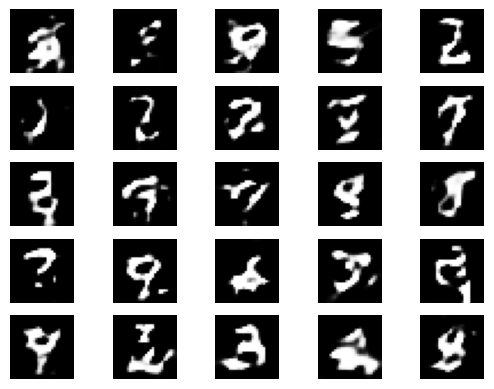

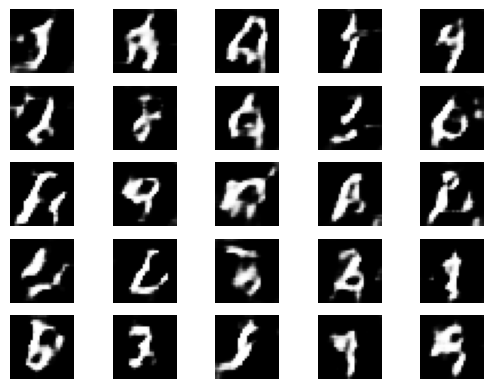

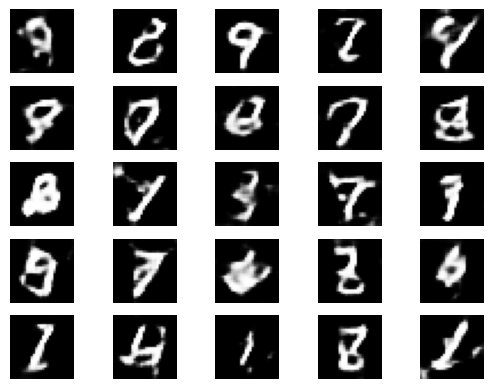

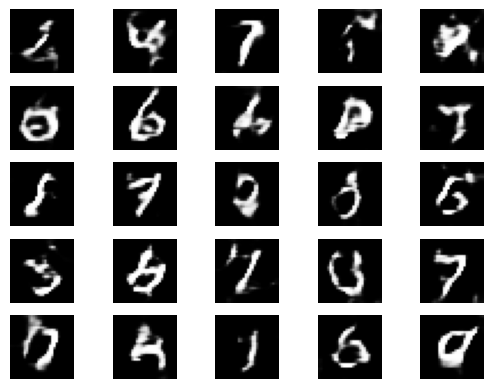

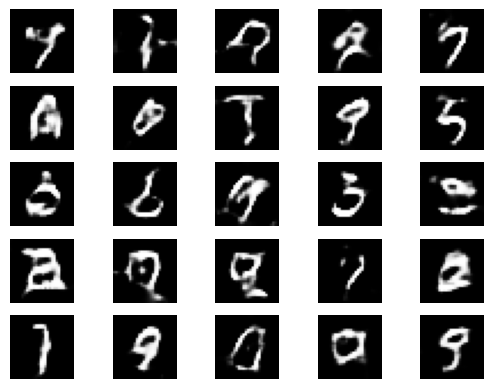

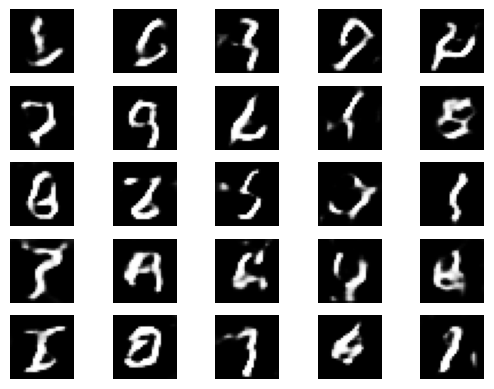

In [6]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

# 생성자 모델 만들기
# 모델 이름을 generator로 정하고 Sequential() 함수 호출
generator = Sequential()
# 128 : 임의로 정한 노드의 수 
# input_dim=100dms 100차원 크기의 랜덤 벡터를 준비해 집어넣으라는 의미
# 7*7 : 이미지의 최초 크기를 의미
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
# 컨볼루션 레이어가 받아들일 수 있는 형태로 바꾸어 주는 코드 
generator.add(Reshape((7, 7, 128)))
# 두 배씩 업(up)샘플링을 한 후 컨볼루션 과정을 처리
generator.add(UpSampling2D())
# padding='same' : 입력과 출력의 크기가 다를 경우 자동으로 크기를 확장해주고 0을 채워넣는다.
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
# LeakyReLU(0.2) : 0보다 작을 경우 0.2를 곱하라는 의미
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 판별자 모델 만들기
# 모델 이름을 discriminator로 정하고 Sequential() 함수를 호출
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
# Flatten() : 가로 x 세로의 2차원으로 진행된 과정을 1차원으로 바꾸어준다.
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
# 판별이 끝나고 나면 판별자 자신이 학습되지 않게끔 학습기능을 꺼준다.
discriminator.trainable = False

# 생성자와 판별자를 연결하는 GAN 모델 생성
# 입력값이 100개의 값으로 이루어진 데이터 / shape(100,) : 뒤의 값을 비워주면 자동적으로 실제 총 데이터개수로 채워짐(데이터 전체수)
ginput = Input(shape=(100,))      
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

def gan_train(epoch, batch_size, saving_interval):      # 세 가지 변수 지정

# MNIST 데이터 불러오기
    # MNIST 데이터를 다시 불러와 이용. 단, 테스트 과정은 필요 없고
    # 이미지만 사용할 것이기 때문에 X_train만 호출
    (X_train, _), (_, _) = mnist.load_data()

    # 가로 28픽셀, 세로 28픽셀이고 흑백이므로 1로 설정
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

    # 0~255 사이 픽셀 값에서 127.5를 뺀 후 127.5로 나누면 -1 ~ 1 사이 값으로 바뀜.
    X_train = (X_train - 127.5) / 127.5

    # batch_size : 한번에 몇 개의 실제 이미지와 몇 개의 가상 이미지를 판별자에 넣을지 결정하는 변수
    # 실제 이미지를 입력했으므로 '모두 참(1)'이라는 레이블을 붙인다
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
        # 실제 데이터를 판별자에 입력하는 부분
        # np.random.randint(a, b, c) : a부터 b까지 숫자 중 하나를 랜덤하게 선택해 가져오는 과정을 c번 반복하라는 의미 
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        # train_on_batch(x, y) : 입력 값(x)과 레이블(y)을 받아서 딱 한 번 학습을 실시해 모델을 업데이트한다.(한 번 호출 -> 한 번 학습)
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # 가상 이미지를 판별자에 입력하는 부분
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        # 판별자와 생성자의 오차를 계산 
        # d_loss_real, d_loss_fake 값을 더해 둘로 나눈 평균이 바로 판별자의 오차 
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)     # 판별자 오차
        g_loss = gan.train_on_batch(noise, true)            # 생성자 오차

        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 중간 과정을 이미지로 저장하는 부분
        # 정해진 인터벌만큼 학습되면 그때 만든 이미지를 gan_images 폴더에 저장하라는 의미 
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("./data/gan_images/gan_mnist_%d.png" % i)

# 2000번 반복되고(+1을 하는 것에 주의)
# 배치 크기는 32, 200번마다 결과가 저장 
gan_train(2001, 32, 200) 


# 오토인코더
입력 데이터의 특징을 효율적으로 담아낸 이미지를 만들어낸다

In [7]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape

import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터셋을 불러온다
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델 만들기
autoencoder = Sequential()

# 인코딩 부분
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28, 28, 1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분 
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))
autoencoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 8, 8, 8)         

Epoch 1/50
469/469 [==============================] - 29s 60ms/step - loss: 0.0851 - val_loss: 0.0830
Epoch 2/50
469/469 [==============================] - 70s 149ms/step - loss: 0.0841 - val_loss: 0.0832
Epoch 3/50
469/469 [==============================] - 85s 182ms/step - loss: 0.0840 - val_loss: 0.0831
Epoch 4/50
469/469 [==============================] - 79s 169ms/step - loss: 0.0840 - val_loss: 0.0829
Epoch 5/50
469/469 [==============================] - 75s 159ms/step - loss: 0.0840 - val_loss: 0.0831
Epoch 6/50
469/469 [==============================] - 27s 58ms/step - loss: 0.0839 - val_loss: 0.0827
Epoch 7/50
469/469 [==============================] - 27s 58ms/step - loss: 0.0838 - val_loss: 0.0829
Epoch 8/50
469/469 [==============================] - 27s 58ms/step - loss: 0.0837 - val_loss: 0.0827
Epoch 9/50
469/469 [==============================] - 27s 57ms/step - loss: 0.0837 - val_loss: 0.0825
Epoch 10/50
469/469 [==============================] - 27s 57ms/step - loss: 0

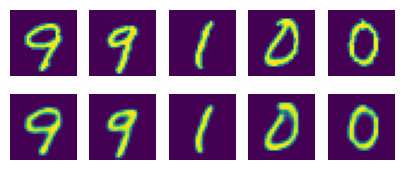

In [9]:
# 컴파일 및 학습을 하는 부분
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분
random_test = np.random.randint(X_test.shape[0], size=5)

# 테스트할 이미지를 랜덤으로 호출 
ae_imgs = autoencoder.predict(X_test)   # 앞서 만든 오토인코더 모델에 넣는다.

plt.figure(figsize=(7, 2))      # 출력 이미지의 크기를 정한다

for i, image_idx in enumerate(random_test):
    ax = plt.subplot(2, 7, i+1)
    plt.imshow(X_test[image_idx].reshape(28, 28))
    ax.axis('off')
    ax = plt.subplot(2, 7, 7 + i +1)
    plt.imshow(ae_imgs[image_idx].reshape(28, 28))
    ax.axis('off')
plt.show()